In [90]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pywt
import cv2
from skimage.draw import polygon2mask
from skimage.measure import find_contours
import pywt
from matplotlib.colors import LogNorm
import math

In [91]:
def get_ttl_trace(timestamps_table, timestamps_table_names, timeorigin, timebinning=1):
    """
    Extracts the TTL trace from the movie specs.

    Args:
    - timestamps_table (np.ndarray): Timestamps table containing TTL data.
    - timestamps_table_names (np.ndarray): Column names for the timestamps table.
    - timeorigin (int): Starting index for the TTL signal.
    - timebinning (int, optional): Time binning factor for downsampling (default: 1).

    Returns:
    - np.ndarray: Extracted TTL signal.
    """
  
    # Get the column index for 'behavior_ttl'
    ttl_column = timestamps_table_names.index("behavior_ttl")

    # Extract the raw TTL signal starting from `timeorigin`
    ttl_signal_raw = timestamps_table[ttl_column, int(timeorigin):]

    # Apply binning if `timebinning` is greater than 1
    if timebinning > 1:
        # Ensure the length of ttl_signal_raw is divisible by timebinning
        trimmed_length = len(ttl_signal_raw) - (len(ttl_signal_raw) % timebinning)
        ttl_signal_raw = ttl_signal_raw[:trimmed_length]
        
        # Reshape, average over bins, and round the result
        ttl_signal = np.round(np.mean(ttl_signal_raw.reshape(-1, timebinning), axis=1))
    else:
        ttl_signal = ttl_signal_raw

    onsets = np.where(np.diff(ttl_signal) == 1)[0] 

    return onsets

In [101]:
def movie_path(mouse, date, file):
    """Returns the file path for a given movie recording."""
    return "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF.h5'

def mask_movie(movie, raw_mask, binning):
    """
    Applies a spatial mask to a movie to exclude non-brain regions.

    Args:
    - movie (numpy.ndarray): 3D array representing the movie (t, x, y).
    - raw_mask (numpy.ndarray): 2D mask array.
    - binning (float): Scaling factor for resizing the mask.

    Returns:
    - numpy.ndarray: The masked movie with non-brain regions removed.
    """
    # Resize the mask using bilinear interpolation
    mask = cv2.resize(raw_mask, (0, 0), fx=1/binning, fy=1/binning, interpolation=cv2.INTER_LINEAR)
    
    # Ensure mask has the same shape as the movie
    movie_size = movie.shape[1:3]  # Get spatial dimensions of the movie
    mask = mask[:movie_size[0], :movie_size[1]]  # Crop mask to match movie size
    mask = mask.astype(bool)         # Convert to boolean mask
    return movie * mask  # Apply mask

def mask_region(movie, raw_outlines, binning, spaceorigin, region, plot=False):
    """
    Applies a mask to a movie based on anatomical brain region outlines.

    Args:
    - movie (numpy.ndarray): 3D movie array (t, x, y).
    - raw_outlines (numpy.ndarray): 3D array of brain region outlines.
    - binning (float): Scaling factor for spatial binning.
    - spaceorigin (numpy.ndarray): 2D array of space origin coordinates.
    - region (str): Brain region to mask ('V1' or 'SSC').
    - plot (bool, optional): Whether to display the mask overlay on the first frame of the movie.

    Returns:
    - numpy.ndarray: The masked movie where only the selected region remains.
    """

    # Define the corresponding outline indices for the selected brain region
    if region == 'V1':
        indices=[37]
    elif region == 'SSC':
        indices=[3,11,13,15]
    else:
        print('Region must be V1 or SSC')

    spaceorigin = (spaceorigin - 1) / binning + 1  # Apply space origin transformation

    # Extract all outlines and scale them according to binning
    outlines_nums = np.arange(raw_outlines.shape[2]) 
    outlines = raw_outlines[:, :, outlines_nums] / binning

    outlines[:, 0, :] -= spaceorigin[1] - 1  # Adjust Y-coordinates
    outlines[:, 1, :] -= spaceorigin[0] - 1  # Adjust X-coordinates

    # Define the movie dimensions
    movie_shape = movie.shape[1:3]  # (height, width)
            
    if plot:
    # Plot the first movie frame
        plt.figure(figsize=(6, 6))
        plt.imshow(movie[0])  # Display movie frame
        plt.title(f"Movie with {region} Outline")

    total_mask = np.zeros(movie_shape, dtype=bool)

    for i in indices:
        # Extract the ROI outline
        outline = outlines[i, :, :]  # Shape (2, N)

        valid_indices = ~np.isnan(outline).any(axis=0)  # Find non-NaN indices
        x_coords = outline[1, valid_indices]
        y_coords = outline[0, valid_indices]

        # Create a mask using polygon2mask
        roi_mask = polygon2mask(movie_shape, np.column_stack((y_coords, x_coords)))
        roi_mask = np.flipud(roi_mask).astype(bool)
        total_mask |= roi_mask  # Any pixel belonging to at least one ROI remains unmasked

    # Apply mask to the movie
    movie_roi = movie * total_mask  # Broadcasting applies the mask to all frames

    # Find contours of the ROI mask
    contours = find_contours(total_mask, level=0.5)  # Extract the outline

    if plot:
        # Overlay the mask outline
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], color='red', linewidth=1.5)  # Plot contour in red
    plt.show()

    return movie_roi

def load_and_mask(path_movie):
    """
    Loads a movie file, applies masking, and optionally extracts a specific brain region.

    Args:
    - mouse (str): Mouse identifier.
    - date (str or int): Experiment date in YYMMDD format.
    - file (str): Recording file identifier.
    - region (str, optional): Brain region to isolate ('V1' or 'SSC'). If None, the full movie is returned.

    Returns:
    - movie (numpy.ndarray): 3D array (t, x, y) representing the processed movie.
    - fps (float): Frames per second of the movie.
    """

    with h5py.File(path_movie, 'r') as mov_file:
        specs = mov_file["specs"]
        mov = mov_file['mov'][()]  
        fps = specs["fps"][()][0][0][0]  
        raw_mask = specs["extra_specs"]["mask"][()][0]
        binning = specs["binning"][()][0][0][0]
        raw_outlines = specs["extra_specs"]["allenMapEdgeOutline"][()]
        spaceorigin = specs["spaceorigin"][()].flatten()  

        timeorigin = specs["timeorigin"][()][0][0][0]
        timebinning = specs["timebinning"][()][0][0]
        timestamps_table = specs["extra_specs"]["timestamps_table"][()].squeeze()
        timestamps_table_names = specs["extra_specs"]["timestamps_table_names"][()]
        timestamps_table_names = b''.join(timestamps_table_names.flatten()).decode("utf-8").split(';')

    onsets = get_ttl_trace(timestamps_table, timestamps_table_names, timeorigin, timebinning)

    # Replace NaN values in the movie
    movie = np.nan_to_num(mov)

    # Apply the brain mask to remove non-brain regions
    movie = mask_movie(movie, raw_mask, binning)

    # If a specific brain region is provided, apply the corresponding region mask
    movie = mask_region(movie, raw_outlines, binning, spaceorigin, 'V1', plot=False)

    return movie, fps, onsets

In [93]:
def dynamic_spectrum(signal, fps, plot=False):
    """
    Computes the dynamic spectrum (time-frequency array) of a 1D signal using the Complex Morlet Wavelet.
    Args:
    - signal (numpy.ndarray): 1D array representing the signal over time.
    - fps (float): Frames per second of the signal =
    - plot (bool, optional): If True, plots the dynamic spectrum. Default is False.
    Returns:
    - power_norm (numpy.ndarray): Normalized power of the wavelet transform.
    - frequencies (numpy.ndarray): Corresponding frequency values.
    """

    wavelet = 'cmor2.0-1.0'  # Complex Morlet wavelet

    # Define Frequency-Optimized Scales
    desired_freqs = np.linspace(1, 40, 100)
    scales = pywt.central_frequency(wavelet) * fps / desired_freqs

    # Compute Wavelet Transform
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet, 1 / fps)
    power = np.abs(coefficients) ** 2  # Compute power spectrum

    # Keep Only Frequencies Below 30 Hz
    valid_idx = (frequencies >= 1.5) & (frequencies <= 40)
    frequencies = frequencies[valid_idx]
    scales = scales[valid_idx]
    power = power[valid_idx, :]  # Keep only low-frequency data
    power = power / scales[:, np.newaxis]
    
    return power, frequencies

In [97]:
#Visual\cfm001mjr\20231208\meas00
#Visual\cmm002mjr\20231208\meas00
#Visual\cmm001mjr\20231212\meas04

#path_movie  = 'n:/GEVI_Wave/Analysis/Visual/cfm002mjr/20240523/meas03/cG_unmixed_dFF.h5'
#path_movie  = 'n:/GEVI_Wave/Analysis/Visual/cfm001mjr/20231208/meas00/cG_unmixed_dFF.h5'
path_movie  = 'n:/GEVI_Wave/Analysis/Visual/cmm001mjr/20231212/meas04/cG_unmixed_dFF.h5'

In [102]:
movie, fps, onsets = load_and_mask(path_movie)

In [103]:
all_power = []

for onset in onsets:
    # Compute frame range for this trial
    start_frame = int(onset - 1*fps)  # Ensure non-negative index
    end_frame = int(onset + 2*fps)  # Ensure within bounds

    if end_frame > len(movie) or start_frame < 0:
        continue

    # Extract trial snippet
    trial_clip = np.nan_to_num(movie[start_frame:end_frame])
    mean_signal = trial_clip.mean(axis=(1, 2))

    # Compute dynamic spectrum and add to list
    power, frequencies = dynamic_spectrum(mean_signal, fps)

    all_power.append(power)

In [107]:
fps

np.float64(157.18327569957034)

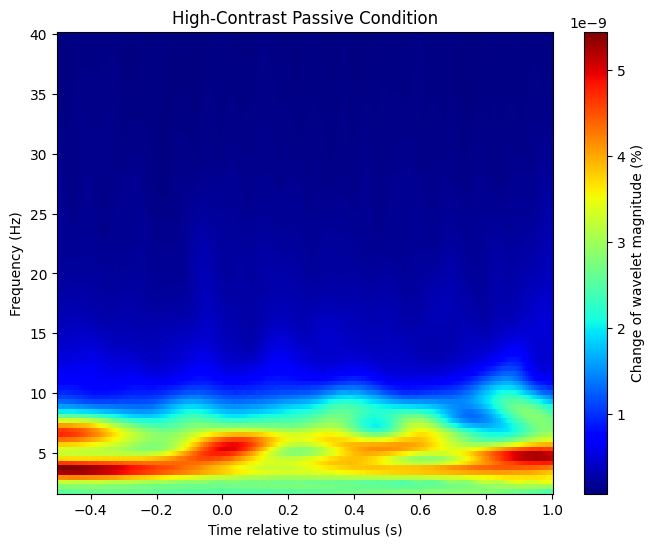

In [104]:
all_power_arr = np.stack([arr[:,int(0.5*fps):-int(0.5*fps)] for arr in all_power])
mean_power_arr = np.mean(all_power_arr[:], axis=0)

# Plot Dynamic Spectrum with Higher
time_arr = np.linspace(-0.5, 1, mean_power_arr.shape[1])  # Stimulus at t=0]
T, F = np.meshgrid(time_arr, frequencies)  # Generate grid

plt.figure(figsize=(8, 6))
plt.pcolormesh(T, F, mean_power_arr, shading='auto', cmap='jet')  # Fine-grained frequency resolution
plt.colorbar(label="Change of wavelet magnitude (%)")
plt.xlabel("Time relative to stimulus (s)")
plt.ylabel("Frequency (Hz)")
plt.title('High-Contrast Passive Condition')
#plt.savefig(f'dynamic_spectra_hcpv')
plt.show()

In [83]:
def plot_spectra_grid(power_arr, freqs, time_arr):
    cols = 4
    rows = math.ceil(len(power_arr) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(16, 3 * rows), constrained_layout=True)
    axs = axs.flatten()

    for i, power in enumerate(power_arr):
        T, F = np.meshgrid(time_arr, freqs)
        im = axs[i].pcolormesh(T, F, power, shading='auto', cmap='jet')
        axs[i].set_xlabel("Time (s)")
        axs[i].set_ylabel("Freq (Hz)")
        cbar = fig.colorbar(im, ax=axs[i])
        cbar.set_label("Power (% change)", fontsize=8)
        cbar.ax.tick_params(labelsize=8)

    for ax in axs[len(power_arr):]:
        ax.axis('off')
    #plt.suptitle(title)
    plt.show()

In [81]:
time_arr.shape

(316,)

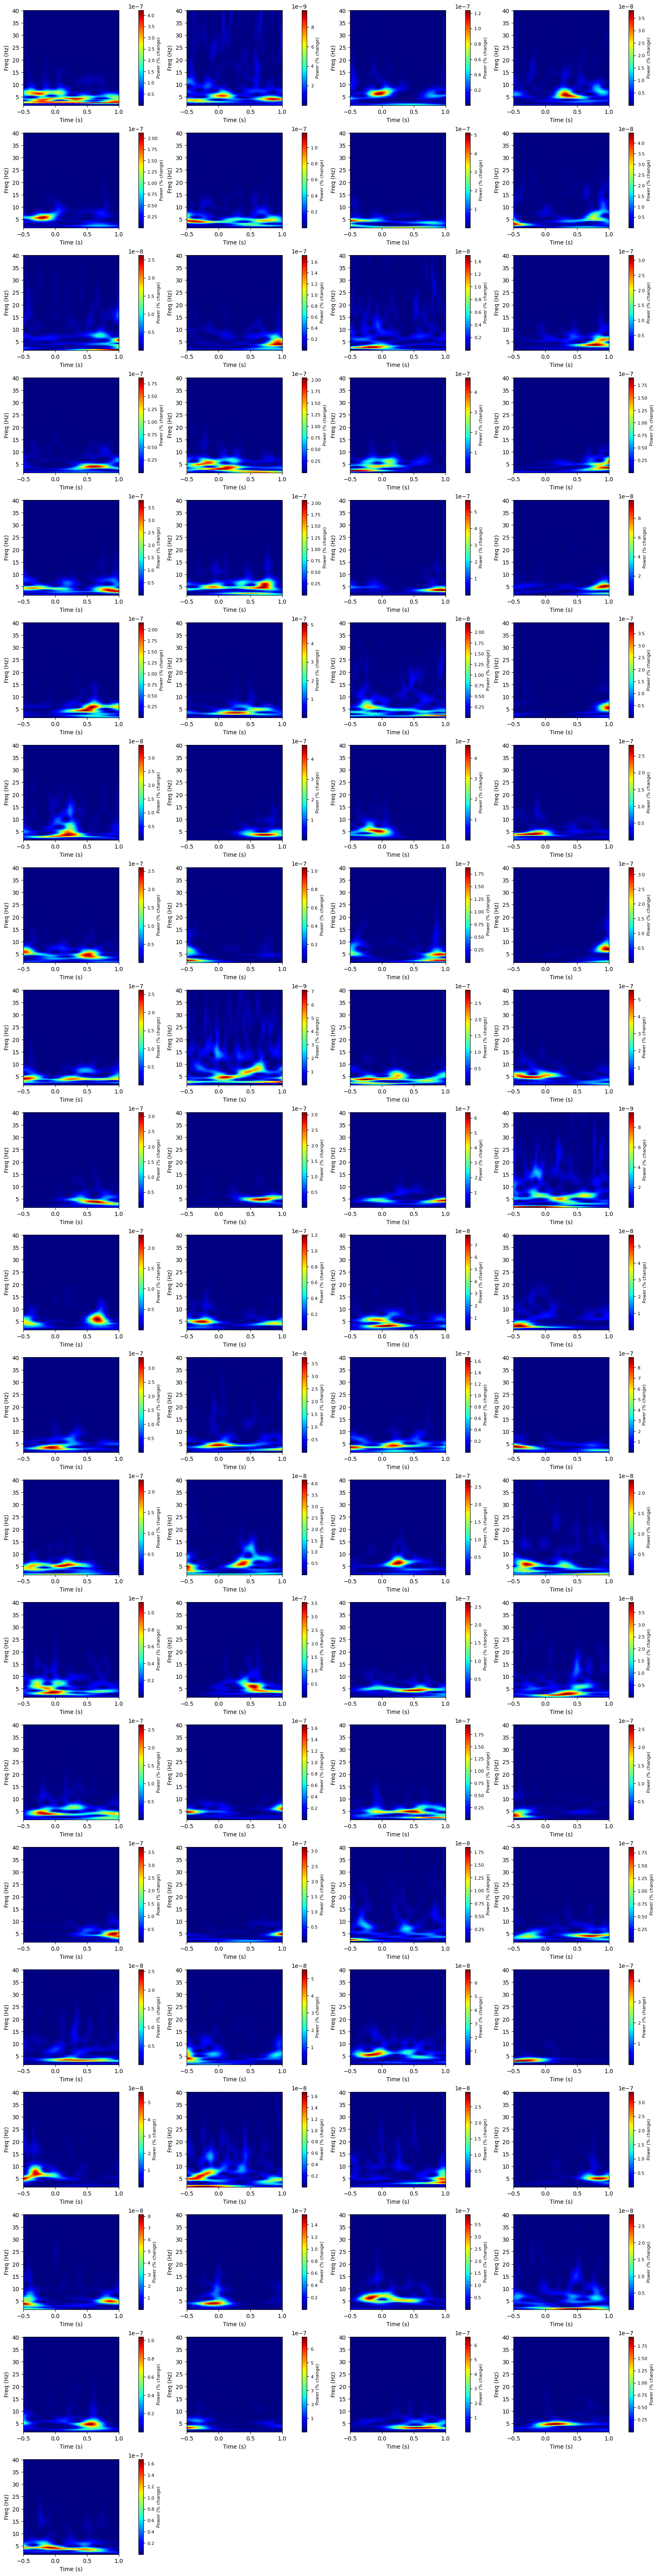

In [84]:
plot_spectra_grid(all_power_arr, frequencies, time_arr)